In [723]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler

In [724]:
def extract_date(df, date_col):
    df.copy(deep=True)
    df['hour'] = df[date_col].dt.hour
    df['month'] = df[date_col].dt.month
    df['year'] = df[date_col].dt.year
    df['week'] = df[date_col].dt.week
    df['day'] = df[date_col].dt.dayofyear
    return df 

### Load Hourly MEFs from Simple Dispatch Model

In [759]:
df_2017 = pd.read_csv('simple_dispatch_mef/final_mefs_PJM_2017.csv', parse_dates = [1])
df_2016 = pd.read_csv('simple_dispatch_mef/final_mefs_PJM_2016.csv', parse_dates = [1])

In [760]:
df_2017 = df_2017[['datetime', 'co2_marg', 'demand']]

In [761]:
df_2016 = df_2016[['datetime', 'co2_marg', 'demand']]

In [768]:
df_2017['datetime'] = pd.to_datetime(df_2017['datetime'])

In [770]:
# Drop outliers
df_2017 = df_2017[df_2017.co2_marg < 2000]
df_2017 = extract_date(df_2017, 'datetime')

df_2016 = df_2016[df_2016.co2_marg < 2000]
df_2016 = extract_date(df_2016, 'datetime')

In [775]:
df_2016

,datetime,co2_marg,demand,hour,month,year,week,day
1,2016-01-01 06:00:00,788.637976,19411.6,6,1,2016,53,1
2,2016-01-01 07:00:00,359.225707,19168.0,7,1,2016,53,1
3,2016-01-01 08:00:00,327.704923,18772.4,8,1,2016,53,1
4,2016-01-01 09:00:00,327.650895,18692.7,9,1,2016,53,1
5,2016-01-01 10:00:00,327.650895,18980.1,10,1,2016,53,1
...,...,...,...,...,...,...,...,...
8746,2016-12-31 00:00:00,823.607762,59147.6,0,12,2016,52,366
8747,2016-12-31 01:00:00,876.403378,58374.5,1,12,2016,52,366
8748,2016-12-31 02:00:00,882.683930,59512.8,2,12,2016,52,366
8749,2016-12-31 03:00:00,921.977325,57122.4,3,12,2016,52,366


### Process Data to Predict MEF Directly with Neural Net

##### Combine Import / Export, Weather, and Demand Data Together

In [776]:
co2_marg = pd.concat([df_2017, df_2016], ignore_index=True)

In [777]:
target = co2_marg[['co2_marg', 'year', 'month', 'day', 'hour']]

# Pivot so this is by hour
target = target.pivot_table(index = ['year','month', 'day'], columns="hour", values=['co2_marg'])
target.columns = target.columns.map('{0[0]}|{0[1]}'.format)

In [778]:
target

co2_marg|0  co2_marg|1   co2_marg|2   co2_marg|3  \
year month day                                                      
2016 1     1            NaN         NaN          NaN          NaN   
           2     384.315480  353.961127   361.980222   719.242272   
           3     844.227320  758.273248   777.166724   844.179537   
           4     704.309089  884.626544   498.539945   511.063671   
           5     503.965896  514.780180   556.462459   536.836413   
...                     ...         ...          ...          ...   
2017 12    361  1076.636653  944.539418  1021.215158   918.050412   
           362   917.583543  593.777644   708.590648   670.148658   
           363   585.206352  598.025901   630.686086   635.349298   
           364   910.863582  910.863582   664.022171   742.090264   
           365   758.867830  856.510782   769.659449  1020.499354   

                 co2_marg|4  co2_marg|5  co2_marg|6   co2_marg|7  co2_marg|8  \
year month day                                                                 
2016 1     1            NaN         NaN  788.637976   359.225707  327.704923   
           2     441.794984  497.652513  935.066897   777.948961  789.924548   
           3     525.506921  375.149441  377.527483   371.739383  602.333991   
           4     366.618139  762.919187  643.998706   371.015404  751.968545   
           5     571.847084  375.342819  372.372147   382.810566  373.693606   
...                     ...         ...         ...          ...         ...   
2017 12    361   728.724852  614.683758  801.697245   941.386833  920.370998   
           362   794.747176  920.090772  945.117216  1070.074535  703.379055   
           363   681.025426  865.977465  860.093248   928.335278  871.485095   
           364  1005.112841  900.727290  619.320619   829.211079  770.771878   
           365   969.670840  894.188989  866.326646   740.275223  767.592130   

                 co2_marg|9  ...  co2_marg|14  co2_marg|15  co2_marg|16  \
year month day               ...                                          
2016 1     1     327.650895  ...   804.633514   921.506899  1009.203216   
           2     865.044145  ...   855.886309   855.886309   672.318570   
           3     744.655778  ...   688.688347   547.938485   371.015404   
           4     811.710495  ...   407.872475   391.135019   395.686853   
           5     661.891760  ...   522.941954   854.257221   756.539296   
...                     ...  ...          ...          ...          ...   
2017 12    361   811.172762  ...   781.920256   576.705352   673.169054   
           362  1316.375742  ...   560.532311   557.033613   589.237893   
           363   876.278868  ...   910.394711   649.245931   643.582708   
           364   876.442278  ...   798.567730   886.178731  1025.993050   
           365   865.218958  ...   736.390761   546.753421   543.167448   

                co2_marg|17  co2_marg|18  co2_marg|19  co2_marg|20  \
year month day                                                       
2016 1     1     865.044145   865.044145   924.183960  1069.981478   
           2     406.421425   377.581237   564.634920   911.562462   
           3     371.015404   380.460334   393.077691   371.015404   
           4     375.753935   375.847863   376.455517   376.268659   
           5     725.149082   603.224085   459.206286   383.483326   
...                     ...          ...          ...          ...   
2017 12    361   741.039466   738.009854   936.168896   905.068293   
           362   697.573743   901.375447   412.440940   582.549190   
           363   769.100351  1090.773920   914.231103   940.613870   
           364   729.169136   945.477927   931.287452   825.321467   
           365   811.794246   883.002402   773.553591   856.510782   

                co2_marg|21  co2_marg|22  co2_marg|23  
year month day                                         
2016 1     1    1067.090569   522.488782   656.861963  
           2    1084.37

In [779]:
target = target.dropna()

In [780]:
day_in_four_months = 119
Y_train = target.head(len(target.index) - day_in_four_months)
Y_test = target.tail(day_in_four_months)

### Circular Encoding

In [783]:
# Circular encoding of day of year and month 
def sin_cos_correction(df):
    df = df.reset_index()
    
    df['day_sin'] = np.sin((df['day']-1)*(2.*np.pi/365))
    df['day_cos'] = np.cos((df['day']-1)*(2.*np.pi/365))
    df['month_sin'] = np.sin((df['month']-1)*(2.*np.pi/12))
    df['month_cos'] = np.cos((df['month']-1)*(2.*np.pi/12))
    
    df = df.drop(['month', 'day'], axis=1)
    df = df.set_index(['year', 'month_sin', 'month_cos', 'day_sin', 'day_cos'])
    return df

In [784]:
Y_train = sin_cos_correction(Y_train)
Y_test = sin_cos_correction(Y_test)

In [786]:
Y_train.to_csv("predict_simple_dispatch_v2/Y_train.csv")
Y_test.to_csv("predict_simple_dispatch_v2/Y_test.csv")

## Predictions with Simple Dispatch Model
Take the previous 4 week's MEF to create a function and then given demand, create the plot 

Look at how max demand changes week to week 

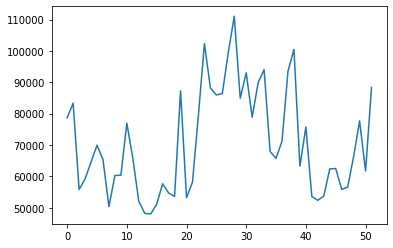

In [654]:
# The largest demand value fluctuates which means that there are some weeks where there's no data 
weekly_df_2017 = df_2017.groupby( ['week'] ).max().reset_index()
weekly_df_2017.demand.plot()

In [655]:
def demand_vs_mef_df(week, simple_dispatch_df):
    prev_week = predict_week - 1
    prev_data = simple_dispatch_df.loc[simple_dispatch_df['week'] == prev_week]

    sim_sorted = prev_data[['demand', 'datetime', 'coal_mix', 'co2_tot', 'so2_tot', 'nox_tot', 'gen_cost_marg']].sort_values(by='demand').copy()
    
    p = 10 
    sim_sorted['dlow'] = list(np.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[0:-p]) + list(np.repeat(0, p/2.))
    sim_sorted['dhigh'] = list(np.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[p:]) + list(np.repeat(0, p/2.))
    sim_sorted['dd'] = sim_sorted.dhigh - sim_sorted.dlow

    e = 'co2'
    sim_sorted[e+'_tot_rolling'] = sim_sorted[e+'_tot'].rolling(window=p*2, min_periods=p*2, center=True).mean()

    sim_sorted[e + 'low'] = list(np.repeat(0, p/2.)) + list(sim_sorted[e + '_tot_rolling'].iloc[0:-p]) + list(np.repeat(0, p/2.))
    sim_sorted[e + 'high'] = list(np.repeat(0, p/2.)) + list(sim_sorted[e + '_tot_rolling'].iloc[p:]) + list(np.repeat(0, p/2.))
    sim_sorted['d'+e] = sim_sorted[e + 'high'] - sim_sorted[e + 'low']
    sim_sorted[e+'slope_0'] = np.divide(sim_sorted['d'+e], sim_sorted.dd)
    sim_sorted[e+'_slope'] = sim_sorted[e+'slope_0'].rolling(window=p, min_periods=p, center=True).mean()
    sim_sorted['gen_cost_marg_rolling'] = sim_sorted['gen_cost_marg'].rolling(window=p*2, min_periods=p*2, center=True).mean()
    
    sim_sorted['dlow'] = list(np.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[0:-p]) + list(np.repeat(0, p/2.))
    sim_sorted['dhigh'] = list(np.repeat(0, p/2.)) + list(sim_sorted.demand.iloc[p:]) + list(np.repeat(0, p/2.))
    sim_sorted['dd'] = sim_sorted.dhigh - sim_sorted.dlow

    df = pd.DataFrame()
    df['x'] = sim_sorted[sim_sorted['co2_slope'].notna()]['demand']/1e3
    df['y'] = sim_sorted[sim_sorted['co2_slope'].notna()]['co2_slope']
    df['week'] = week
    
    return df


In [656]:
def get_mef(demand, df):
    return np.interp(demand//1e3, df.x, df.y)

Generate Predictions Each Week 

In [660]:
# Load demand data 
fossil_gen = pd.read_csv('Predictions/fossil_gen.csv')
fossil_gen = fossil_gen[['year', 'month', 'day', 'hour', 'fossil gen']]

In [661]:
# Add week and datetime columns 

fossil_gen['datetime'] = pd.to_datetime(fossil_gen['year'] * 1000 + fossil_gen['day'], format='%Y%j')

fossil_gen['week'] = fossil_gen['datetime'].dt.week

In [663]:
predicted_mef_df = pd.DataFrame()
for week in range(32, 53):
    df = demand_vs_mef_df(week, df_2017)
    demand_week = fossil_gen.loc[fossil_gen['week'] == week]
    demand_week['predicted_mef'] = get_mef(demand_week['fossil gen'], df)
    
    predicted_mef_df = predicted_mef_df.append(demand_week)


/home/amy/.local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [664]:
predicted_mef_df = predicted_mef_df.rename(columns = {'predicted_mef': 'predicted_with_model'})